distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]
Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2

-1282.5 * IIIIIIIIZ
- 1282.5 * IIIIIIIZI
- 1282.5 * IIIIIIZII
- 1268.5 * IIIIIZIII
- 1268.5 * IIIIZIIII
- 1268.5 * IIIZIIIII
- 1290.0 * IIZIIIIII
- 1290.0 * IZIIIIIII
- 1290.0 * ZIIIIIIII
+ 606.5 * IIIIIIIZZ
+ 606.5 * IIIIIIZIZ
+ 606.5 * IIIIIIZZI
+ 606.5 * II

TypeError: 'int' object is not iterable

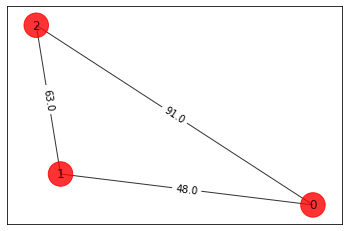

In [7]:
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA
from qiskit.quantum_info.operators import Operator
#from qiskit.optimization.applications.ising import tsp
from qiskit_optimization.applications import Tsp
#from qiskit.aqua.algorithms import NumPyMinimumEigensolver, QAOA
from qiskit.algorithms.minimum_eigensolvers import QAOA , NumPyMinimumEigensolver
#from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
#from qiskit.optimization.problems import QuadraticProgram
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.primitives import Sampler
import matplotlib.pyplot as plt
import networkx as nx
from qiskit.utils import algorithm_globals
# NOTE  Run this Code on IBM Quantum LAB 

#The below code is an implementation of solving TSP with QAOA and VQE
# the errors are in result of probable compatibitlity between Qiskit QAOA and Tsp Function.
#I have submitted the issue on GitHub
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
    
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)
    
# Generating a TSP instance of n cities

n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)


# Create a random TSP Hamiltonian
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print(qubitOp, offset)

algorithm_globals.random_seed = 10598


optimizer = COBYLA()
sampler = Sampler()
qaoa = QAOA(sampler, optimizer, reps=2)


# solving the Problem using QAOA

qaoa_result =qaoa.compute_minimum_eigenvalue(qubitOp)

print("\nQAOA:\n", qaoa_result)

#v = qaoa_result.optimal_circuit

lowest_eigen_value=  qaoa_result.best_measurement['value']
print("energy:", lowest_eigen_value.real)


print("tsp objective:", lowest_eigen_value.real + offset)
print("time:", qaoa_result.optimizer_time)
sample = tsp.sample_most_likely(qaoa_result.eigenstate)
print('sameple',sample)

z = tsp.interpret(sample)


#print('tsp._draw_result(qaoa_result)',tsp._draw_result(sample,pos))
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))

In [8]:
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE

algorithm_globals.random_seed = 123
seed = 10598
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

result = vqe.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))

draw_tsp_solution(tsp.graph, z, colors, pos)

energy: -7326.02469952186
time: 72.70078086853027


TypeError: 'int' object is not iterable

In [71]:
#There is an issue with QAOA function if you use compute_minimum_eigenvalue
#the energy its returning is not matching with VQE min energy but in the result 
#dict it is giving the lowest energy in the value pair.So the above code is working based on that.
algorithm_globals.random_seed = 123
seed = 10598
optimizer = COBYLA()
sampler = Sampler()
qaoa = QAOA(sampler, optimizer, reps=2)


# solving the Problem using QAOA

qaoa_result =qaoa.compute_minimum_eigenvalue(qubitOp)

print("\nQAOA:\n", qaoa_result)

print("tsp objective:", qaoa_result.eigenvalue.real+ offset)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))

draw_tsp_solution(tsp.graph, z, colors, pos)


QAOA:
 SamplingMinimumEigensolverResult:
	Eigenvalue: -216.54100224461524
	Best measurement
: {'state': 84, 'bitstring': '001010100', 'value': (-7379+0j), 'probability': 0.0073193861539587}

tsp objective: 7364.458997755385
energy: -216.54100224461524
time: 4.261896133422852
feasible: True
solution: [0, 0, 0]
solution objective: 0.0
Traceback (most recent call last):
  Cell In[71], line 24
    draw_tsp_solution(tsp.graph, z, colors, pos)
  Cell In[65], line 26 in draw_tsp_solution
    G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
  File /opt/conda/lib/python3.10/site-packages/networkx/classes/coreviews.py:54 in __getitem__
    return self._atlas[key]
KeyError: 0

Use %tb to get the full traceback.
